<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [6.2 A Simple Example of Adjoint Sensitivity Analysis](https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.02-Contributed-Example.html) | [Contents](toc.html) | [6.4 Adjoint Sensitivity Notes on Numerical Computation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.04-Adjoint-Sensitivity-Notes-on-Numerical-Computation.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/06.03-Sensitivity-Analysis-with-Adjoint-Operators.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.03-Sensitivity-Analysis-with-Adjoint-Operators.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 6.3 Sensitivity Analysis with Adjoint Operators

Following [McClarren (2018)](https://link-springer-com.proxy.library.nd.edu/book/10.1007%2F978-3-319-99525-0), let $Q(x, \theta)$ be a quantity of interest where $\theta$ is a parameter. We assume there are additional constraints $f(x, \theta) = 0$ where the Jacobian $f_x(x, \theta)$ is everywhere non-singular. We wish to compute the **parametric sensitivity** $Q_\theta$ where $Q_\theta$ is the total derivative of $Q$ with respect to $\theta$. Parameteric sensitivity appears in a wide range of applications including optimization, error estimation, uncertainty quantification, and inverse problems in imaging and siesmology. 

The subject of the notebook is the particular case where $Q(x, \theta)$ is an inner product of $x$ with a weighting function. In the case, the computation of $Q_\theta$ can be organized into a two step procedure. The first step is to compute an adjoint $y$ which is then followed by computing an inner product of the adjoint with functions derived from the problem data.

This notebook reviews properties of inner products, then demonstrates use of inner products to define and solve for the adjoints of several representative applications of parametric sensitivity.

References

* McClarren, Ryan G., McClarren, and Penrose. Uncertainty Quantification and Predictive Computational Science. Springer International Publishing, 2018. [https://link-springer-com.proxy.library.nd.edu/book/10.1007%2F978-3-319-99525-0](https://link-springer-com.proxy.library.nd.edu/book/10.1007%2F978-3-319-99525-0)

* Bradley, Andrew. PDE-constrained optimization and the adjoint method. [https://cs.stanford.edu/~ambrad/adjoint_tutorial.pdf](https://cs.stanford.edu/~ambrad/adjoint_tutorial.pdf)



In [1]:
# install modules
!pip install autograd

## 6.3.1 Review of inner products

An **inner product** is the 'multiplication' of two vectors, $u$ and $v$, to produce a scalar result  $\langle u, v\rangle$ . 

For real vectors $u$, $v$, and $w$, and a real scalar $\alpha$, an inner product must satisfy four basic properties:

1. Additivity: $\langle u + v, w \rangle = \langle u, w\rangle + \langle v, w\rangle $
2. Homogeneity: $\langle \alpha u, w\rangle = \alpha \langle v, w\rangle$
3. Symmetry: $\langle v, w\rangle  = \langle w, v\rangle$
4. Positivity: $\langle v, v\rangle \geq 0$ and equal to zero if and only if $v = 0$.

An **inner product space** is an a vector space along with an inner product defined on that space. Common examples of inner product spaces include the following cases of general interest in computational science and engineering.

1. Product of real numbers $u$ and $v$ $$\langle u, v\rangle = u v$$
1. Dot product of finite dimensional real vectors. For $u, v \in\text{R}^N$. $$\langle u, v\rangle = u^Tv =\sum_{n=1}^{N}u_nv_n$$
1. Real vector-valued functions on a finite interval $t \in [t_a, t_b]$. Given functions $f$ and $g$ $$\langle f, g\rangle = \int_{t_a}^{t_b}\langle f(t),g(t)\rangle\ dt$$
1. Expected value of the product of random variables. Given random variables $X$ and $Y$ $$\langle X, Y\rangle = \text{E}(XY)$$
1. Real matrices. Given $M \times N$ real matrices $A$ and $B$ in $R^{M \times N}$ $$\langle A, B\rangle = \text{tr}(A^TB) = \sum_{m=1}^M\sum_{n=1}^Na_{mn}b_{mn}$$

A **linear operator**is an operator $L$ that maps a vector into another vector and satisfies properties of additivity and homogeneity.

1. Additivity: $L(u + v) = Lu + Lv$
2. Homogeneity: $L(\alpha u) = \alpha L u$

A basic result for linear operators is that for every linear operator $L$ defined on an inner product space there exists a unique linear **adjoint operator** $L^*$ such that 

$$\langle L^*u, v \rangle \equiv \langle u, Lv \rangle $$

A **self-adjoint** operator is a combination of linear operator and inner product such that $L = L^*$. Finding the adjoint operator, or finding an inner product (if one exists) for which a linear operator is self-adjoint can be challenging analytical problems.


## 6.3.2 Sensitivity Analysis of Linear equations

Suppose there is a quantity of interest (QoI) that can be computed as an inner product

$$Q = \langle c, x\rangle$$

where $x$ is the solution to linear equality constraints

\begin{align*}
A x & = b
\end{align*}

We would like to know how $Q$ changes in response to perturbations in the problem data $A$ and $b$. That is, given perturbations $\delta A$ and $\delta b$ in the problem data, we would like to compute $\delta Q$ where 

$$Q + \delta Q = \langle c + \delta c, x + \delta x\rangle$$

where $x + \delta x$ is the solution to 

$$(A + \delta A)(x + \delta x) = b + \delta b$$

One way to do this, of course, is simply insert specific perturbations into the problem data and solve the equations again. The issue with this approach is that there are are many potential perturbations one would like to investigate. Solving the original equations for every possible case would get expensive and require significant data handling. Is there a better way to get the desired information?




## 6.3.3 Case 1. Perturbations in the RHS

We begin with the case where perturbations to the problem are restricted to the right hand side of the linear equatiopns. For this case, using the properties of the inner product

\begin{align*}
Q + \delta Q & = \langle c, x + \delta x\rangle \\
& = \langle c, x \rangle + \langle c, \delta x \rangle 
\end{align*}

subject to the linear equality constraint

$$A(x + \delta x) = b + \delta b$$

Substracting the nominal value $Q = \langle c, x \rangle$ and the nominal linear solutions  $Ax = b$ leaves 

$$\delta Q = \langle c, \delta x \rangle$$

subject to

$$A\delta x = \delta b$$

One way we could compute $\delta Q$ is solve the last equation for $\delta x = A^{-1}\delta b$ and substitute into $\delta Q$ to give

$$\delta Q = \langle c, A^{-1}\delta b\rangle$$

If $A$ isn't too large, this may be a good way to proceed. But for large dimensional problems we may seek a more direct calculation. Using the properties of adjoint

$$\delta Q= \langle (A^{-1})^*c, \delta b\rangle$$

There is a simple proof that $(A^{-1})^* = (A^*)^{-1}$ which results in

$$\delta Q = \langle (A^*)^{-1}c, \delta b \rangle$$

Taking this one step further, suppose we had a solution to a second system of equations

$$A^*y = c$$

where $A^*$ is the adjoint matrix, then we could write

$$\delta Q = \langle y, \delta b \rangle$$

The advantage of this formulation is that we no longer have to invert a matrix. All we have to do is solve a second system of linear equations using any method available to us, including efficient iterative methods. 

Further, because the coefficients of $y$ describe the dependence of the quantity of interest on the uncertain parameters, $y$ can be interpreted as sensitivity coefficients. For this reason $y$ is sometimes referred to as the **adjoint sensitivity**. 

Often we wish to study the sensitivity of $Q$ to a perturbation in a specific parameter $\theta$ on which $b(\theta)$ depends. In this case we can model

$$\delta b = b_\theta \delta \theta$$

It's a simple matter to show that $\delta Q = Q_\theta \delta \theta$ where

$$Q_\theta = \langle y, b_\theta \rangle$$

which shows the elements of $y$ can be interpreted as the sensitivity of $Q$ to perburbations in the corresponding elements of $b$. 

To summarize, by using the properties of inner products, we can arrive at this same result without having to introduce a matrix inverse.

\begin{align*}
\delta Q & = \langle c, \delta x \rangle \\
& = \langle A^*y, \delta x \rangle \\
& = \langle y, A \delta x \rangle \\
& = \langle y, \delta b \rangle \\
\end{align*}

For specific parametric sensitivies,

$$\boxed{Q_\theta  = \langle y, b_\theta \rangle \text{ where } A^*y = c}$$

This remarkable expression tells us that we don't need to invert a matrix. To get sensititivity coefficients for a quantity of interest we only need to solve one additional system of linear equations. Let's see how this works out for a simple example.


### 6.3.3.1 Example: Multi-product plant

A plant produces two products, X and Y, the produce per-unit revenue of \$270 and \$210, respectively. The fixed costs of production are \$100 and \$90, respectively.  In addition,  each unit of X requires 1 of labor A at \$50 per hour, and 2 hours of labor B at \$40 per  hour. Each unit of Y requires 1 hour of each type of labor. TA total of 80 hours of labor A and 100 hours of labor B are available for production.

Compute the sensitivity of the total plant profit to changes in the amount of available labor.

### 6.3.3.2 Solution

Profit for this process is given by

$$\text{profit} = \text{revenue} - \text{expense}$$

Identifying variables as

\begin{align*}
x_1 & & \text{Units of X produced} \\
x_2 & & \text{Units of Y produced} \\
x_3 & & \text{Hours of Labor A Used} \\
x_4 & & \text{Hours of Labor B Used} \\
\end{align*}

with these definitions

\begin{align*}
\text{revenue} & = 270 x_1 + 210 x_2 \\
\text{expense} & = 100 x_1 + 90 x_2 + 50 x_3 + 40 x_4 \\
\end{align*}

subject to equality constraints

\begin{align*}
x_3 & = x_1 + x_2 \\
x_4 & = 2 x_1 + x_2 \\
x_3 & = 80 \\
x_4 & = 100 \\
\end{align*}

Given these modeling equations, the sensitivity formulation becomes

$$Q = \text{profit} = \langle c, x \rangle$$

where

$$c = \begin{bmatrix} 170 \\ 120 \\ -50 \\ -40 \end{bmatrix}$$

with equality constraints

$$\underbrace{\begin{bmatrix} 1 & 1 & -1 & 0 \\ 2 & 1 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}}_A \underbrace{\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}}_x = \underbrace{\begin{bmatrix} 0 \\ 0 \\ 80 \\ 100 \end{bmatrix}}_b$$

We will use $\theta_A$ and $\theta_B$ to denote additional labor of type A and B, respectively. The perturbed system is  

$$\underbrace{\begin{bmatrix} 1 & 1 & -1 & 0 \\ 2 & 1 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}}_A \underbrace{\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}}_x = \underbrace{\begin{bmatrix} 0 \\ 0 \\ 80  + \theta_A \\ 100 + \theta_B \end{bmatrix}}_b$$

for which 

$$\frac{\partial b}{\partial \theta_A} = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix} \quad \frac{\partial b}{\partial \theta_B} = \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}$$

The desired sensitivity coefficients are

\begin{align*}
\frac{\partial Q}{\partial \theta_A} & = \langle y, \frac{\partial b}{\partial \theta_A} \rangle = \langle \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}\rangle = y_3 \\
\frac{\partial Q}{\partial \theta_B} & = \langle y, \frac{\partial b}{\partial \theta_B} \rangle = \langle \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{bmatrix}, \begin{bmatrix} 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}\rangle = y_4
\end{align*}

The following cell computes the adjoint sensitivity coefficients and compares the results to a direct calculation.


In [2]:
import numpy as np

variables = ("X produced", "Y produced", "Labor A used", "Labor B used")
equations = ("")

c = np.array([170, 120, -50, -40])
A = np.array([[1, 1, -1, 0], [2, 1, 0, -1], [0, 0, 1, 0 ], [0, 0, 0, 1]])
b = np.array([0, 0, 80, 100])

x = np.linalg.solve(A, b)
for var, val in zip(variables, x):
    print(f"{var}: {val}")

profit = np.dot(c, x)
print('\nprofit = ', profit)

y = np.linalg.solve(A.T, c.T)
print('sensitivities', y)

# Verify
dbA = np.array([0, 0, 1, 0 ])
print('\ncomputed change in profit with one additional hour of A = ', np.dot(c, np.linalg.solve(A, b + dbA)) - profit)

dbB = np.array([0, 0, 0, 1 ])
print('computed change in profit with one additional hour of B = ', np.dot(c, np.linalg.solve(A, b + dbB)) - profit)

X produced: 20.0
Y produced: 60.0
Labor A used: 80.0
Labor B used: 100.0

profit =  2600.0
sensitivities [70. 50. 20. 10.]

computed change in profit with one additional hour of A =  20.0
computed change in profit with one additional hour of B =  10.0


## 6.3.4 Case 2. Sensitivity to changes in equation coefficients

Neglecting second-order terms

$$A\delta x + \delta A x = \delta b$$

Beginning with $\delta Q$ and a solution to $A^*y = C$

\begin{align*}
\delta Q & = \langle c, \delta x \rangle \\
& = \langle A^*y, \delta x \rangle \\
& = \langle y, A \delta x \rangle \\
& = \langle y, (\delta b - \delta A x) \rangle \\
& = \langle y, \delta b \rangle - \langle y, \delta A x \rangle \\
\end{align*}

for perturbations that depend on specific parameters,

\begin{align*}
\implies Q_\theta & = \langle y, b_\theta \rangle - \langle y, A_\theta x \rangle 
\end{align*}


### 6.3.4.1 Example

As a continuation of the previous example, consider modificatins to the manufacturing process modifications that would reduce the labor required to produce each unit of product. 

1. Using a sensitivity analysis, estimate the increased profit that would result from reducing the amount of labor B required to produce each unit of product X.  The solve for the actual profit as a function of the labor reduction and compare to the sensitivity result.

2. Extend the analysis by computing the sensitivity of profit to changes in the labor required for each type of labor in each product.


### 6.3.4.2 Solution

Refering the model equations developed above, the equality constraints read

$$\underbrace{\begin{bmatrix} 1 & 1 & -1 & 0 \\ \boxed{2 - \theta} & 1 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}}_A \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix} = \underbrace{\begin{bmatrix} 0 \\ 0 \\ 80 \\ 100 \end{bmatrix}}_b$$

where the required labor of type B required to produce a unit of product X has been highlighted. The parameter $\theta$ has been added to this entry to indicate the reduction in the amount of labor required to produce the first product. Taking the derivative,

$$A_\theta = \begin{bmatrix} 0 & 0 & 0 & 0 \\ -1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{bmatrix}$$

The desired sensitivity coefficient is computed as

$$ Q_\theta = - \langle y, A_\theta x \rangle $$

where

\begin{align*}
A x & = b \\
A^T y & = c
\end{align*}

In this case, $Q_\theta$ is the sensitivity of profit to reduction in the labor of type B required to produce the first product.



In [3]:
import numpy as np
import matplotlib.pyplot as plt

c = np.array([170, 120, -50, -40])
A = np.array([[1, 1, -1, 0], [2, 1, 0, -1], [0, 0, 1, 0 ], [0, 0, 0, 1]])
b = np.array([0, 0, 80, 100])

x = np.linalg.solve(A, b)
print('forward solution = ', x)

profit = np.dot(c, x)
print('profit = ', profit)

y = np.linalg.solve(A.T, c.T)
print('sensitivities', y)

dA = np.zeros([4, 4])
dA[1, 0] = -1
print(dA)
dP = -np.dot(y, np.dot(dA, x))
print('sensitivity =', dP)

# compare sensitivity projection with computational solutions
def profit(c, A, b):
    return np.dot(c, np.linalg.solve(A, b))

theta = np.linspace(0, 0.5, 100)
plt.plot(theta, [profit(c, A + t*dA, b) for t in theta], label="Sensitivity estimate")
plt.plot(theta, [profit(c, A, b) + t*dP for t in theta], label="Computed solution")
plt.xlabel('Decrease in labor B hours required per unit of A')
plt.title('Profit')
plt.legend()

print("\nmatrix of sensitivity coefficients")
np.array([[y[i]*x[j] for j in range(len(x))] for i in range(len(y))])

forward solution =  [ 20.  60.  80. 100.]
profit =  2600.0
sensitivities [70. 50. 20. 10.]
[[ 0.  0.  0.  0.]
 [-1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
sensitivity = 1000.0

matrix of sensitivity coefficients


array([[1400., 4200., 5600., 7000.],
       [1000., 3000., 4000., 5000.],
       [ 400., 1200., 1600., 2000.],
       [ 200.,  600.,  800., 1000.]])

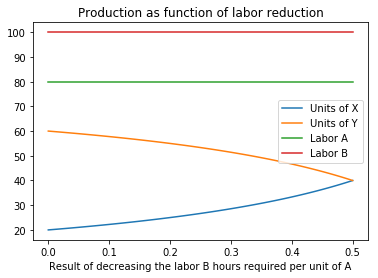

In [4]:
theta = np.linspace(0, 0.5, 100)
plt.plot(theta, [np.linalg.solve(A + t*dA, b) for t in theta])
plt.xlabel('Result of decreasing the labor B hours required per unit of A')
plt.title('Production as function of labor reduction')
plt.legend(["Units of X", "Units of Y","Labor A", "Labor B"])

## 6.3.5 Case 3. Generic Case

The final case is the situation with parametric changes in $A$, $b$, and $c$. Starting with

$$Q = \langle c, x\rangle$$

subject to linear equality constraints

\begin{align*}
A x & = b
\end{align*}

We would like to know how $Q$ depends on perturbations in the $A$, $b$, and $c$. That is, we would like to compute

\begin{align*}
Q + \delta Q & = \langle c + \delta c, x + \delta x\rangle \\
& = \langle c, x\rangle + \langle \delta c, x \rangle + \langle c, \delta x \rangle + \langle \delta c, \delta x \rangle
\end{align*}

which, after subtracting $Q = \langle c, x\rangle$, leaves

$$\delta Q = \langle \delta c, x \rangle + \langle c, \delta x \rangle + \langle \delta c, \delta x \rangle$$

subject to 

$$(A + \delta A)(x + \delta x) = b + \delta b$$

Expanding and subtracting $Ax = B$ leaves

$$\delta A x + A\delta x + \delta A\delta x = \delta b$$

Dropping second order terms leaves the pair of equations

\begin{align*}
\delta Q = \langle \delta c, x \rangle + \langle c, \delta x \rangle \\
\delta A x + A\delta x = \delta b
\end{align*}

Next take the inner product of terms in the second equation with $y$, the solution to the adjoint equation $A^*y = c$.

\begin{align*}
\delta Q = \langle \delta c, x \rangle + \langle c, \delta x \rangle \\
\langle y, \delta A x \rangle + \langle y, A\delta x \rangle = \langle y, \delta b \rangle
\end{align*}

Taking the inner product with the solution to $A^*y = c$ gives

\begin{align*}
\delta Q & = \langle \delta c, x \rangle + \langle c, \delta x \rangle \\
\langle A^*y, \delta x \rangle & = \langle y, \delta b \rangle - \langle y, \delta A x \rangle
\end{align*}

Substituting $A^*y = $ gives the desired result showing how the quantity of interest $Q$ changes as a result of perturbations in $c$, $b$, or $A$.

$$\delta Q = \langle x, \delta c \rangle + \langle y, \delta b \rangle - \langle y, \delta A x \rangle$$

For parametric sensitivity one has a final formula

$$\boxed{
\begin{align*}
Q_\theta & = \langle x, c_\theta \rangle + \langle y, b_\theta \rangle - \langle y, A_\theta x \rangle \\
\\ \text{where}
\\
& A x = b \\
& A^T y = c \\
\end{align*}}$$







## 6.3.6 Systems of first-order linear differential equations

## 6.3.7 Application: Pharmacokinetics





[Kaldate, Rajesh R et al. “Modeling the 5-fluorouracil area under the curve versus dose relationship to develop a pharmacokinetic dosing algorithm for colorectal cancer patients receiving FOLFOX6.” The oncologist vol. 17,3 (2012): 296-302. doi:10.1634/theoncologist.2011-0357](doi:10.1634/theoncologist.2011-0357)

[Morawska, Katarzyna et al. “5-FU therapeutic drug monitoring as a valuable option to reduce toxicity in patients with gastrointestinal cancer.” Oncotarget vol. 9,14 11559-11571. 30 Jan. 2018. doi:10.18632/oncotarget.24338](doi:10.18632/oncotarget.24338)

[Walko, Christine M. "Using Pharmacokinetics to Optimize Older Chemotherapeutic Agents." (2014)](https://www.cancernetwork.com/view/using-pharmacokinetics-optimize-older-chemotherapeutic-agents)

#### 6.3.7.1 Linear pharmacokinetics

The system of interest is a compartment model for linear pharmacokinetics of a therapeutic drug

\begin{align*}
V\frac{dC}{dt} & = -K C + u \\
C(t_a) & = 0 
\end{align*}

where $C$ is a vector of compartment concentrations, $V$ a diagonal matrix of compartment volumes, $K$ a matrix of reaction and elimination rate parameters, and $u$ is vector of compartmental drug administration rates. 

For the purposes of evaluating a proposed therapy, we identify the linear operator

$$\mathcal{L}x = V\frac{dx}{dt} + Kx \quad \text{with} \quad x(t_a) = 0$$ 

and the inner product

$$\langle y, x \rangle = \int_{t_a}^{t_b} y^T(t) x(t)\ dt$$

A conventional metric for evaluating a proposed therapy $u(t)$ on the interval $[t_a, t_b]$ is to solve the equation

$$\mathcal{L}x = u$$

and evaluate the quantity of interest, the area under the curve (AUC), using the inner product

$$Q = \text{AUC} = \langle c, x \rangle$$

where $c(t) = 1$.



### 6.3.7.1 Finding the adjoint operator

Identifying the linear operator $\mathcal{L}x = V\frac{dx}{dt} + Kx$ with initial condition $x(t_a) =  0$, we find an expression for the adjoint operator.

\begin{align*}
\langle y, \mathcal{L} x \rangle & = \int_{t_a}^{t_b} y^T (V\frac{dx}{dt} + K x)\ dt \\
& = \int_{t_a}^{t_b} y^T V\frac{dx}{dt}\ dt  + \int_{t_a}^{t_b} y^T K x\ dt \\
& = y^T(t_b)Vx(t_b) - y^T(t_a)V\underbrace{x(t_a)}_0 - \int_{t_a}^{t_b} \frac{dy}{dt}^T Vx\ dt  + \int_{t_a}^{t_b} y^T K x\ dt \\
\end{align*}

Setting $y(t_b) = 0$

\begin{align*}
\langle y, \mathcal{L} x \rangle & = - \int_{t_a}^{t_b} \frac{dy}{dt}^T Vx\ dt  + \int_{t_a}^{t_b} y^T K x\ dt \\
& = \int_{t_a}^{t_b} (-\frac{d (V^Ty)}{dt}^T + (K^Ty)^T)x\ dt \\
& = \langle \mathcal{L}^* y, x \rangle \\
\end{align*}

where for a diagonal matrix $V^T = V$ we have identified the adjoint operator

\begin{align*}
\boxed{\mathcal{L}^*y = - V\frac{dy}{dt} + K^Ty \quad \text{with} \quad y(t_b) = 0}
\end{align*}

### 6.3.7.2 Example: One compartment model

A one compartment model is characterized by a volume $V$ and elimination rate $k$.

$$\mathcal{Lx} = u \quad \text{with} \quad x(0) = 0$$

where

$$\mathcal{L} = V\frac{dx}{dt} + kx$$

The adjoint sensitivity for area under the curve (AUC) satisfies the equation

$$\mathcal{L}^*y = 1 \quad \text{with} \quad y(t_f) = 0$$

where

$$\mathcal{L}^*y = -V\frac{dy}{dt} + k y$$

The next cell demonstrates the response of a one compartment model to constant infusion of a therapeutic drug for a finite period of time, and computation of the associated adjoint sensitivity function.

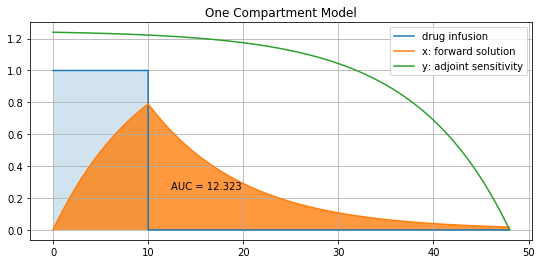

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, trapz

def pkmodel(tf, k, V):
    """
    Returns time, input, concentration, and adjoint sensitivity for a
    one-compartment pharmacokinetic model.
    """
    # forward solution 
    u = lambda t: 1 if t < 10 else  0
    def L(t, x, u):
        return -k*x/V + u(t)/V 
    t = np.linspace(0, tf, 10001)
    soln = solve_ivp(lambda t, y: L(t, y, u), (0, tf), (0,), t_eval=t, rtol=1e-7)
    u = np.array([u(t) for t in t])
    x = soln.y[0]

    # adjoint sensitivity
    def Ladj(t, y, c):
        return k*y/V - c(t)/V
    c = lambda t: 1
    sens = solve_ivp(lambda t, y: Ladj(t, y, c), (tf, 0), (0,), t_eval=np.flipud(t), rtol=1e-7)
    y = np.flipud(sens.y[0])

    return t, u, x, y

def AUC(t, x):
    """Returns area under the curve"""
    return trapz(x, t)

def pkvisualize(t, u, x, y):

    fig, ax = plt.subplots(1, 1, figsize=(9, 4))

    ax.plot(t, u, label='drug infusion')
    ax.fill_between(t, u, alpha=0.2)

    ax.plot(t, x, label="x: forward solution")
    ax.fill_between(t, x, alpha=0.8)
    ax.text(t[np.argmax(x)] + 0.05*max(t), np.mean(x), f"AUC = {AUC(t, x):6.3f}", ha="left")
    ax.plot(t, y, label="y: adjoint sensitivity")

    ax.set_title('One Compartment Model')
    ax.legend();
    ax.grid(True)

# parameter values
k_nominal = 0.8
V_nominal = 8
tf = 48

pkvisualize(*pkmodel(tf, k_nominal, V_nominal))

### 6.3.7.3 Example: Sensitivity to changes in elimination rate $k$

The sensitivity analysis for the system of linear equations extends naturally to the case of first-order linear differential equations. Adjusting for notation,

$$\boxed{\frac{\partial Q}{\partial \theta} = \langle x, \frac{\partial c}{\partial \theta} \rangle + \langle y, \frac{\partial u}{\partial \theta} \rangle - \langle y, \frac{\partial \mathcal{L}}{\partial \theta} x \rangle}$$

Consider, for example, a change in the elimination constant $k$ in the coomputational example. The linear operator reads

$$\mathcal{Lx} = V\frac{dx}{dt} + k x \quad \text{with} \quad x(t_a) = 0$$

$$\implies \frac{\partial \mathcal{L}}{\partial k} = 1 $$

$$\implies  \frac{\partial Q}{\partial k} = - \langle y, x \rangle$$

$$\implies \boxed{\delta Q \approx - \delta k \langle y, x \rangle}$$

Given a change in elimination rate $\delta k$, the next cell compares this estimate of $\delta Q$ to the result of a full simulation.

Estimated change in AUC  -1.1577541344944497
Actual Change in AUC -1.0648666184487983


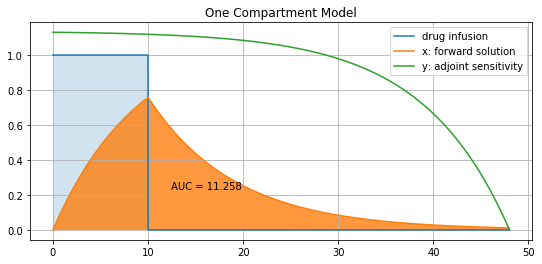

In [6]:
# parameter values
k_nominal = 0.8
V_nominal = 8
tf = 48
dk = 0.1*k_nominal

# baseline simulation
t, u, x, y = pkmodel(tf, k_nominal, V_nominal)

# sensitivity estimate
def innerproduct(t, x, y):
    return trapz(x*y, t)

print('Estimated change in AUC ', -dk*innerproduct(t, x, y))

# simulation
kt, ku, kx, ky = pkmodel(tf, k_nominal + dk, V_nominal)
pkvisualize(kt, ku, kx, ky)

print("Actual Change in AUC", AUC(kt, kx) - AUC(t, x))

Next we show how the estimate of $\delta Q$ constructed using the adjoint sensitivity compares to simulations over a range of parameter values.

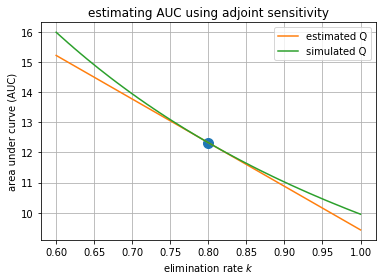

In [7]:
# parameter values
k_nominal = 0.8
V_nominal = 8
tf = 48
dk = 0.25*k_nominal

# baseline simulation
t, u, x, y = pkmodel(tf, k_nominal, V_nominal)
plt.plot(k_nominal, AUC(t, x), '.', ms=20)

# estimate Q as function of k
k = k_nominal + dk*np.linspace(-1, 1, 101)
Q_est = AUC(t, x) - (k - k_nominal)*innerproduct(t, x, y)
plt.plot(k, Q_est, label="estimated Q")

# calculate actual Q vs k
def Q(tf, k, V):
    t, _, x, _ = pkmodel(tf, k, V)
    return AUC(t, x)

Q_sim = [Q(tf, k, V_nominal) for k in k]
plt.plot(k, Q_sim, label="simulated Q")

plt.xlabel("elimination rate $k$")
plt.ylabel("area under curve (AUC)")
plt.title("estimating AUC using adjoint sensitivity")
plt.legend()
plt.grid(True)

### 6.3.7.4 Example: Sensitivity to changes in compartment volume $V$

$$\mathcal{Lx} = V\frac{dx}{dt} + k x \quad \text{with} \quad x(t_a) = 0$$

$$\implies \frac{\partial \mathcal{L}}{\partial V} = \frac{d}{dt} $$

$$\implies  \frac{\partial Q}{\partial V} = - \langle y, \frac{dx}{dt} \rangle$$

$$\implies \boxed{\delta Q \approx - \delta V \langle y, \frac{dx}{dt} \rangle}$$

Estimated change in AUC  -0.01922826831506073
Actual Change in AUC -0.02120952361984152


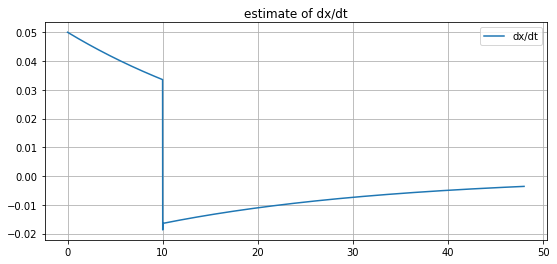

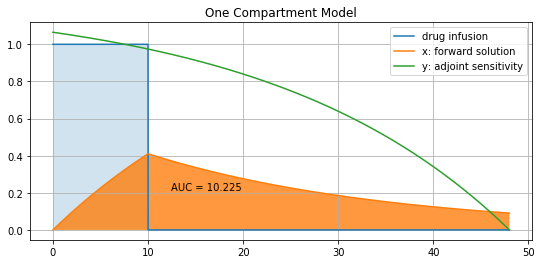

In [8]:
# parameter values
k_nominal = 0.8
V_nominal = 20
tf = 48
dV = 0.1

# baseline simulation
t, u, x, y = pkmodel(tf, k_nominal, V_nominal)

# estimate derivative
dx = np.gradient(x, np.mean(np.diff(t)))
plt.figure(figsize=(9, 4))
plt.plot(t, dx, label="dx/dt")
plt.title('estimate of dx/dt')
plt.legend()
plt.grid(True)
print('Estimated change in AUC ', -dV*innerproduct(t, dx, y))

# simulation
vt, vu, vx, vy = pkmodel(tf, k_nominal, V_nominal + dV)
pkvisualize(vt, vu, vx, vy)
print("Actual Change in AUC", AUC(vt, vx) - AUC(t, x))

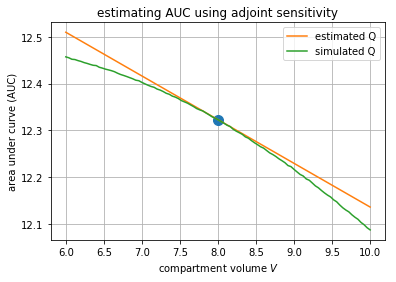

In [9]:
# parameter values
k_nominal = 0.8
V_nominal = 8
tf = 48
dV = 0.25*V_nominal

# baseline simulation
t, u, x, y = pkmodel(tf, k_nominal, V_nominal)
plt.plot(V_nominal, AUC(t, x), '.', ms=20)

# estimate Q as function of V
V = V_nominal + dV*np.linspace(-1, 1, 101)
dx = np.gradient(x, np.mean(np.diff(t)))
Q_est = AUC(t, x) - (V - V_nominal)*innerproduct(t, dx, y)
plt.plot(V, Q_est, label="estimated Q")

# calculate actual Q vs V
Q_sim = [Q(tf, k_nominal, V) for V in V]
plt.plot(V, Q_sim, label="simulated Q")

plt.xlabel("compartment volume $V$")
plt.ylabel("area under curve (AUC)")
plt.title("estimating AUC using adjoint sensitivity")
plt.legend()
plt.grid(True)

## 6.3.8 Systems of first-order nonlinear differential equations

Next we consider a system of first-order differential equations given in the form

\begin{align*}
F(t, x, \dot{x}, \theta) & = 0 \\
x(t_0) & = x_0
\end{align*}

where $\theta$ is a parameter. We wish do determine the sensitivity of a quantity of interest $Q$ to small changes in $\theta$ where $Q$ can be expressed as an inner product

$$Q = \langle w, x \rangle =  \int_{t_0}^{t_f} w^T(t)x(t)\ dt$$

for some vector-valued weighting function $w(t)$ defined on the interval $[t_0, t_f]$.

To proceed, we introduce an auxiliary vector-valued function $y(t)$ that will serve as a weighting function for $F$. The Lagrangian is then defined as

\begin{align*}
L & = Q - \langle y, F \rangle
\end{align*}

Because $F(t, x, \dot{x}, \theta) = 0$ for any solution to the differential equations, the quantity of interest will be equal to the value of the Lagrangian for any choice of $y(t)$. What we seek is a choice for $y(t)$ that goes one step further and enables us to compute the sensitivity of $Q$ to small changes in $\theta$.

From this point forward we will use a subscript notation to denote gradients of a function with respect to scalar or vector-valued arguments. Recursive applications of the chain rule

\begin{align*}
L_{\theta} & = Q_\theta - \langle y, F \rangle_\theta \\
& = \langle w, x \rangle_\theta - \langle y, F \rangle_\theta \\
& = \langle w_\theta, x \rangle + \langle w, x_\theta \rangle - \langle y, F_\theta \rangle - \langle y, F_xx_\theta \rangle - \langle y, F_\dot{x}\dot{x}_\theta \rangle  \\
\end{align*}

The problem with this equation is that we don't know $x_\theta(t)$ or $\dot{x}_\theta(t)$, so we seek a strategy for removing them from the right-hand side. The first step is an integration by parts

\begin{align*}
\langle y, F_\dot{x}\dot{x}_\theta \rangle & = \langle F_\dot{x}^Ty, \dot{x}_\theta \rangle\\
& = y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} - \langle (F_{\dot{x}}^Ty)_t, x_\theta \rangle  \\
& = y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} - \langle F_{\dot{x}t}^Ty, x_\theta \rangle  - \langle F_{\dot{x}}^T\dot{y}, x_\theta \rangle \\
& = y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} - \langle y, F_{\dot{x}t}x_\theta \rangle - \langle \dot{y}, F_{\dot{x}}x_\theta \rangle  
\end{align*}

Rearranging these results and introducing the matrix adjoints

\begin{align*}
L_{\theta}
& = \langle w_\theta, x \rangle - \langle y, F_\theta \rangle - y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} + \langle w, x_\theta \rangle - \langle y, F_xx_\theta \rangle + \langle y, F_{\dot{x}t}x_\theta \rangle + \langle \dot{y}, F_{\dot{x}}x_\theta \rangle  \\
& = \langle w_\theta, x \rangle - \langle y, F_\theta \rangle - y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} + \langle w, x_\theta \rangle - \langle F_x^Ty, x_\theta \rangle + \langle F_{\dot{x}t}^Ty, x_\theta \rangle + \langle F_{\dot{x}}^T\dot{y}, x_\theta \rangle  \\
& = \langle w_\theta, x \rangle - \langle y, F_\theta \rangle - y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} + \langle w - F_x^Ty +  F_{\dot{x}t}^Ty + F_{\dot{x}}^T\dot{y}, x_\theta \rangle \\
\end{align*}

This is a scalar expression incorporating values of $x_\theta$. The dependence on $x_\theta$ can be eliminated by choosing $y$ to satsify a two-point boundary value problem

\begin{align*}
F_\dot{x}^T\dot{y} + (F_{\dot{x}t}^T - F_x^T)y + w &  = 0 \\
y^T F_\dot{x}x_\theta\vert_{t_0}^{t_f} & = 0\\
\end{align*}

If $x(t_0)$ is fixed so that $x_\theta(t_0) = 0$, and $F_\dot{x}$ is full rank at the end points, then the solution for $y(t)$ simplifies to 

\begin{align*}
F_\dot{x}^T\dot{y} + (F_{\dot{x}t}^T - F_x^T)y + w &  = 0 \\
y(t_f) & = 0\\
\end{align*}

In this case the solution for $y(t)$ can be found by first solving the original differential equations for $x(t)$, then using the solution to integrate the above system of differential equations from $t_f$ back to $t_0$. 

With the additional assumption $x_\theta(t_0) = 0$, this equality can be achieved by defining $y(t)$ as the solution to the differential equations. Once $x(t)$ ane $y(t)$ are known, by construction of $L$, the desired sensitivity is given by 

$$\boxed{Q_\theta = L_\theta = \langle w_\theta, x \rangle - \langle y, F_\theta \rangle}$$




### 6.3.8.1 Example: Over-damped oscillator

$$ m\ddot{x} + (c  + \theta)\dot{x} + k x = 0$$

which can be rewritten as 

\begin{align*}
\begin{bmatrix} 1 & 0 \\ 0 & m \end{bmatrix} \begin{bmatrix}\dot{x}_1 \\  \dot{x}_2 \end{bmatrix} 
+ \begin{bmatrix} 0 & -1 \\ k & c+\theta \end{bmatrix} \begin{bmatrix}x_1 \\ x_2 \end{bmatrix} =  \begin{bmatrix}0 \\ 0 \end{bmatrix}
\end{align*}

\begin{align*}
F_\dot{x} & = \begin{bmatrix} 1 & 0 \\ 0 & m \end{bmatrix}  \\
F_{\dot{x}t} & = 0 \\
F_x & = \begin{bmatrix} 0 & -1 \\ k & c+\theta \end{bmatrix} \\
F_\theta & = \begin{bmatrix}0 \\ x_1 \end{bmatrix}
\end{align*}


2.3815663241270446 -32122.140068184468


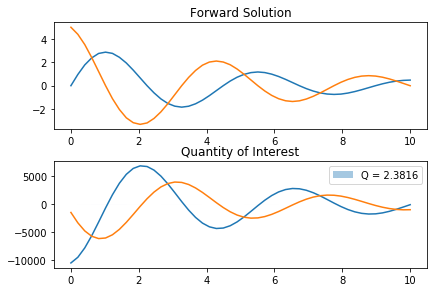

In [10]:
%matplotlib inline

import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, trapz
from scipy.interpolate import interp1d

# default model parameters
m = 0.5
c = .2
k = 1
IC = (0, 5)

# simulation parameters
t_span = (0, 10)

# closures make it easy to create multiple models with different parameter values
def damped_osc(m=m, c=c, k=k, theta=0):
    # model equations
    Fxdot = np.array([[1, 0], [0, m]])
    Fx = np.array([[0, -1], [k, c + theta]])
    return lambda t, x: np.dot(-np.dot(np.linalg.inv(Fxdot), Fx), x)

# the forward solution returns an interpolation function
def forward(deriv, t_span, IC):
    soln = solve_ivp(deriv, t_span, IC, rtol=1e-8)
    return interp1d(soln.t, soln.y)

# forward solution
x = forward(damped_osc(), t_span, IC)

# plot solution
fig, ax = plt.subplots(2, 1)
fig.tight_layout()
t = np.linspace(*t_span)
ax[0].plot(t, [x(t) for t in t])
ax[0].set_title("Forward Solution")

# quantity of interest
w = lambda t: np.array([1, 0]) if t >= 0 else np.array([0, 0])
def innerproduct(t, w, x):
    return trapz([np.dot(w(t), x(t)) for t in t], t)
Q = innerproduct(t, w, x)

# plot quantity of interest and value
ax[1].fill_between(t, [np.dot(w(t), x(t)) for t in t], alpha=0.4)
ax[1].set_title("Quantity of Interest")
ax[1].legend([f"Q = {Q:6.4f}"])

# adjoint model
Fxdot = np.array([[1, 0], [0, m]])
Fx = np.array([[0, -1], [k, c]])
A  = np.dot(np.linalg.inv(Fxdot), Fx)
ydot = lambda t, y: -np.dot(A.T, y) - w(t)

# backward solution
backward = solve_ivp(ydot, (tf, 0), (0, 0), rtol=1e-8)
y = interp1d(backward.t, backward.y)

ax[1].plot(t, [y(t) for t in t])

Q = np.trapz([x(t)[0] for t in t], t)
Qc = np.trapz([x(t)[0]*y(t)[1] for t in t], t)
print(Q, Qc)

## 6.3.9 Systems of first-order differential equations

A system of time-invariant differential equationsl with fixed initial conditions written as

\begin{align*}
\dot{x} & = f(t, x, \theta) \\
x(t_0) & = x_0
\end{align*}

can be rewritten as

\begin{align*}
F(t, x, \dot{x}, \theta) & = \dot{x} - f(t, x, \theta) \\
x(t_0) & = x_0
\end{align*}

From this we compute

\begin{align*}
F_\dot{x} & = I \\
F_{\dot{x}t} & = 0 \\
F_x & = -f_x(t, x, \theta) \\
F_\theta & = -f_\theta(t, x, \theta)
\end{align*}

The adjoint equations become 

\begin{align*}
\dot{y} & =  -f_x^T(t, x, \theta)y - w(t) \\
y(t_f) & = 0\\
\end{align*}

Autograd tutorials

* [http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf)


### 6.3.9.1 Example: Preditor-prey dynamics of the Hare/Lynx system

See [https://jckantor.github.io/CBE30338/02.05-Hare-and-Lynx-Population-Dynamics.html](https://jckantor.github.io/CBE30338/02.05-Hare-and-Lynx-Population-Dynamics.html) for the detailed model and background to this application.

Predicted change: 18.890552485529707
Actual change: 20.07420089541847


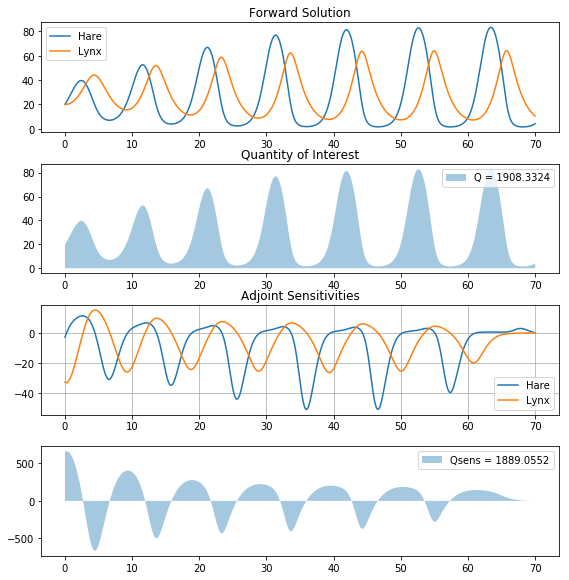

In [11]:
%matplotlib inline
import autograd.numpy as np
from autograd import jacobian
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# APPLICATION SPECIFIC

labels = ["Hare", "Lynx"]
t_span = np.array([0, 70])
IC = np.array((20, 20))

# use closures to create models for different parameter values
def preditor_prey(a=3.2, b=0.6, c=50, d=0.56, k=125, r=1.6):
    def deriv(t, x, perturbation=0.0):
        H, L = x
        dH =  r*H*(1 - H/k) - a*H*L/(c + H)
        dL = b*a*H*L/(c + H) - (d + perturbation)*L
        return np.array([dH, dL])
    return deriv
f = preditor_prey()

# weighting function to compute the quantity of interest
w = lambda t: np.array([1.0, 0.0])

# GENERIC SENSITIVITY ANALYSIS
rtol = 1e-10

# generic function to return the value of an innerproduct of two vector-valued functions
def innerproduct(w, x, t_span):
    """Returns numerical value of the inner product of two vector-valued functions over t_span."""
    return solve_ivp(lambda t, q: np.dot(w(t), x(t)), t_span, np.array([0.0]), rtol=rtol).y[0][-1]

# the forward solution returns the quantity of interest and an interpolation function for x(t)
def forward(deriv, t_span, IC):
    """Return a function that computes x(t)"""
    soln = solve_ivp(deriv, t_span, IC, rtol=rtol)
    return interp1d(soln.t, soln.y)

x = forward(f, t_span, IC)
Q = innerproduct(w, x, t_span)

# adjoint sensitivity and parametric sensitivity coefficient
def backward(w, f, t_span): 
    """Return a function that computes y(t)"""
    ydot = lambda t, y: -np.dot(jacobian(f, 1)(t, x(t)).T, y) - w(t)
    soln = solve_ivp(ydot, np.flipud(t_span), np.zeros(len(IC)), rtol=rtol)
    return interp1d(soln.t, soln.y)

y = backward(w, f, t_span)
Qp = innerproduct(y, lambda t: jacobian(f, 2)(t, x(t), 0.0), t_span)

# VISUALIZATION AND VALIDATION

# compare to actual simulation
delta = 0.01
Qa = innerproduct(w, forward(lambda t,x: f(t, x, delta), t_span, IC), t_span)
print(f"Predicted change: {delta*Qp}")
print(f"Actual change: {Qa - Q}")

# plot solution
t = np.linspace(*t_span, 1001)
fig, ax = plt.subplots(4, 1, figsize=(8,8))
fig.tight_layout()
ax[0].plot(t, [x(t) for t in t])
ax[0].set_title("Forward Solution")
ax[0].legend(labels)
ax[1].fill_between(t, [np.dot(w(t), x(t)) for t in t], alpha=0.4)
ax[1].set_title("Quantity of Interest")
ax[1].legend([f"Q = {Q:6.4f}"])
ax[2].plot(t, [y(t) for t in t])
ax[2].set_title("Adjoint Sensitivities")
ax[2].legend(labels)
ax[2].grid(True)
ax[3].fill_between(t, [np.dot(y(t), jacobian(f, 2)(t, x(t), 0.0)) for t in t], alpha=0.4)
ax[3].legend([f"Qsens = {Qp:6.4f}"])


### 6.3.9.2 Example: Managing COVID-19 on a College Campus

See [https://github.com/jckantor/covid-19](https://github.com/jckantor/covid-19) for detail on this model.

Predicted change: 0.001863947447262933
Actual change: 0.001963600667473947


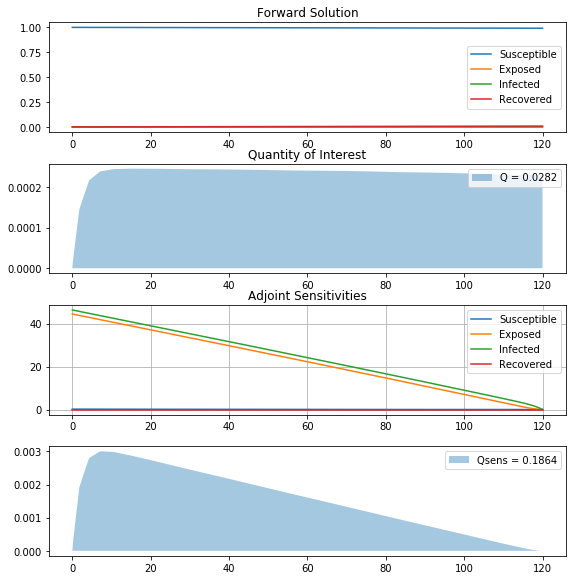

In [12]:
%matplotlib inline
import autograd.numpy as np
from autograd import jacobian
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# APPLICATION SPECIFIC

labels = ["Susceptible", "Exposed", "Infected", "Recovered"]
t_span = np.array([0, 120])

N = 16000.0
n = 10.0

e_initial = n/N
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

IC = np.array([s_initial, e_initial, i_initial, r_initial])

# use closures to create models for different parameter values
def seir(R0=2.4, t_incubation=5.1, t_infective=3.3, u=0.37):
    def deriv(t, x, theta=0.0):
        s, e, i, r = x
        alpha = 1/t_incubation
        gamma = 1/t_infective
        beta = (R0 + theta)*gamma
        dsdt = -(1-u)*beta * s * i
        dedt =  (1-u)*beta * s * i - alpha * e
        didt = alpha * e - gamma * i
        drdt =  gamma * i
        return np.array([dsdt, dedt, didt, drdt])
    return deriv
f = seir(R0=1.0, u=0.0)

# weighting function to compute the quantity of interest
w = lambda t: np.array([0.0, 0.0, 1.0, 0.0])

# GENERIC SENSITIVITY ANALYSIS
rtol = 1e-10

# generic function to return the value of an innerproduct of two vector-valued functions
def innerproduct(w, x, t_span):
    """Returns numerical value of the inner product of two vector-valued functions over t_span."""
    return solve_ivp(lambda t, q: np.dot(w(t), x(t)), t_span, np.array([0.0]), rtol=rtol).y[0][-1]

# the forward solution returns the quantity of interest and an interpolation function for x(t)
def forward(deriv, t_span, IC):
    """Return a function that computes x(t)"""
    soln = solve_ivp(deriv, t_span, IC, rtol=rtol)
    return interp1d(soln.t, soln.y)

x = forward(f, t_span, IC)
Q = innerproduct(w, x, t_span)

# adjoint sensitivity and parametric sensitivity coefficient
def backward(w, f, t_span): 
    """Return a function that computes y(t)"""
    ydot = lambda t, y: -np.dot(jacobian(f, 1)(t, x(t)).T, y) - w(t)
    soln = solve_ivp(ydot, np.flipud(t_span), np.zeros(len(IC)), rtol=rtol)
    return interp1d(soln.t, soln.y)

y = backward(w, f, t_span)
Qp = innerproduct(y, lambda t: jacobian(f, 2)(t, x(t), 0.0), t_span)

# VISUALIZATION AND VALIDATION

# compare to actual simulation
delta = 0.01
Qa = innerproduct(w, forward(lambda t,x: f(t, x, delta), t_span, IC), t_span)
print(f"Predicted change: {delta*Qp}")
print(f"Actual change: {Qa - Q}")

# plot solution
t = np.linspace(*t_span, 1001)
fig, ax = plt.subplots(4, 1, figsize=(8,8))
fig.tight_layout()
ax[0].plot(t, [x(t) for t in t])
ax[0].set_title("Forward Solution")
ax[0].legend(labels)
ax[1].fill_between(t, [np.dot(w(t), x(t)) for t in t], alpha=0.4)
ax[1].set_title("Quantity of Interest")
ax[1].legend([f"Q = {Q:6.4f}"])
ax[2].plot(t, [y(t) for t in t])
ax[2].set_title("Adjoint Sensitivities")
ax[2].legend(labels)
ax[2].grid(True)
ax[3].fill_between(t, [np.dot(y(t), jacobian(f, 2)(t, x(t), 0.0)) for t in t], alpha=0.4)
ax[3].legend([f"Qsens = {Qp:6.4f}"])


### 6.3.9.3 Exercise: Application to an exothermic stirred tank reactor

\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}

Solving for the derivatives

\begin{align*}
\frac{dc_A}{dt} & = \frac{q}{V}(c_{Ai} - c_A)- kc_A \\
\frac{dT}{dt} & = \frac{q}{V}(T_i - T) + \frac{-\Delta H_R}{\rho C_p}kc_A + \frac{UA}{V\rho C_p}(T_c - T)
\end{align*}

which are the equations that will be integrated below.

| Quantity | Symbol | Value | Units | Comments |
| :------- | :----: | :---: | :---- | |
| Activation Energy | $E_a$ | 72,750 | J/gmol | |
| Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
| Gas Constant | $R$ | 8.314 | J/gmol/K | |
| Reactor Volume | $V$ | 100 | liters | |
| Density | $\rho$ | 1000 | g/liter | |
| Heat Capacity | $C_p$ | 0.239 | J/g/K | |
| Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
| Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
| Feed flowrate | $q$ | 100 | liters/min | |
| Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
| Feed temperature | $T_f$ | 350 | K | |
| Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
| Initial temperature | $T_0$ | 350 | K | |
| Coolant temperature | $T_c$ | 300 | K | Primary Manipulated Variable |


In [13]:
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q = 100.0       # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5;      # Initial concentration [mol/L]
T0  = 350.0;    # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

def deriv(y,t):
    cA,T = y
    dcA = (q/V)*(cAi - cA) - k(T)*cA
    dT = (q/V)*(Ti - T) + (-dHr/rho/Cp)*k(T)*cA + (UA/V/rho/Cp)*(Tc-T)
    return [dcA,dT]

In [14]:
# visualization
def plotReactor(t,y):
    plt.subplot(1,2,1)
    plt.plot(t,y[:,0])
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [gmol/liter]')
    plt.title('Concentration')
    plt.ylim(0,1)

    plt.subplot(1,2,2)
    plt.plot(t,y[:,1])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [K]');
    plt.title('Temperature')
    plt.ylim(300,450)
    plt.legend([Tc])

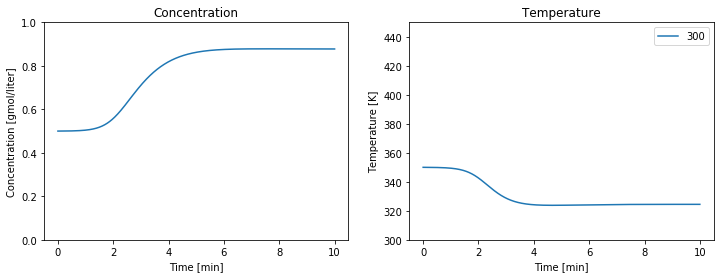

In [15]:
from scipy.integrate import odeint

Tc = 300
IC = [cA0,T0]
t = np.linspace(0,10.0,2000)
y = odeint(deriv,IC,t)

plt.figure(figsize=(12,4))
plotReactor(t,y);

<!--NAVIGATION-->
< [6.2 A Simple Example of Adjoint Sensitivity Analysis](https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.02-Contributed-Example.html) | [Contents](toc.html) | [6.4 Adjoint Sensitivity Notes on Numerical Computation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.04-Adjoint-Sensitivity-Notes-on-Numerical-Computation.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/06.03-Sensitivity-Analysis-with-Adjoint-Operators.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/06.03-Sensitivity-Analysis-with-Adjoint-Operators.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>